# Применение генетического алгоритма на реальных данных Mall Customers

В данном файле будут выполнены загрузка, анализ и визуализация реального датасета `mall_customers` и его кластеризация с последующей оценкой качества кластеризации.


## Загрузка данных и первичный анализ


In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import shapiro
from experiment import experiment
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv("mall_customers.csv")
display(df.head())
display(df.describe())

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [4]:
print("Количество пропусков:\n")
print(df.isnull().sum())

Количество пропусков:

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


**Вывод**
- В данных нет пропусков.
- Признак `CustomerID` не несет никакой информации.
- Категориальный признак `Genre`

## Визуализация и отбор признаков

In [4]:
# удалим 'CustomerID'
df_dropped = df.drop(["CustomerID"], axis=1)
# преобразим категориальный признак 'Genre' в числовой
df_dropped["Genre"] = LabelEncoder().fit_transform(df_dropped["Genre"])

In [5]:
df_dropped.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


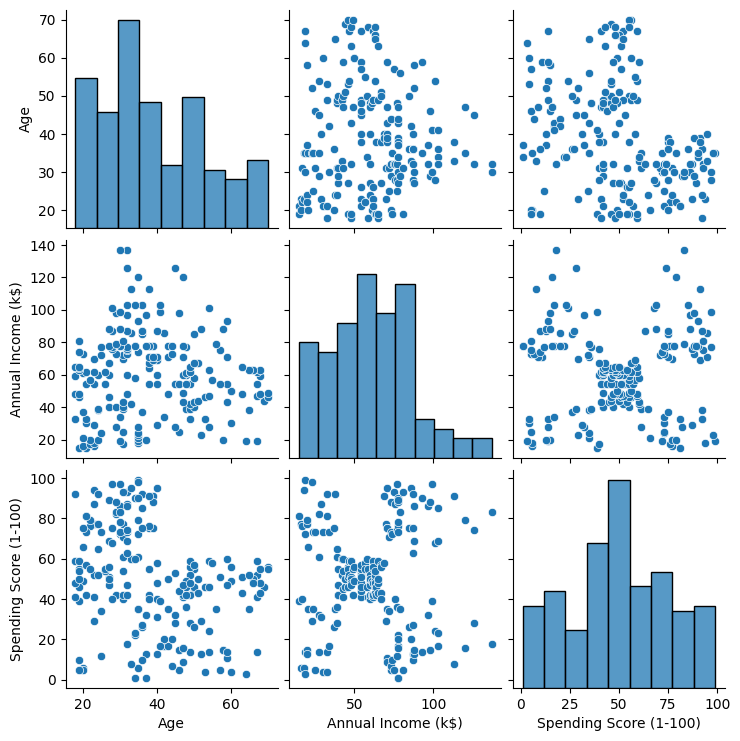

In [6]:
sns.pairplot(df_dropped.drop(["Genre"], axis=1))
plt.show()

fig = px.scatter_3d(
    df, "Age", "Annual Income (k$)", "Spending Score (1-100)", color="Genre"
)
fig.show()

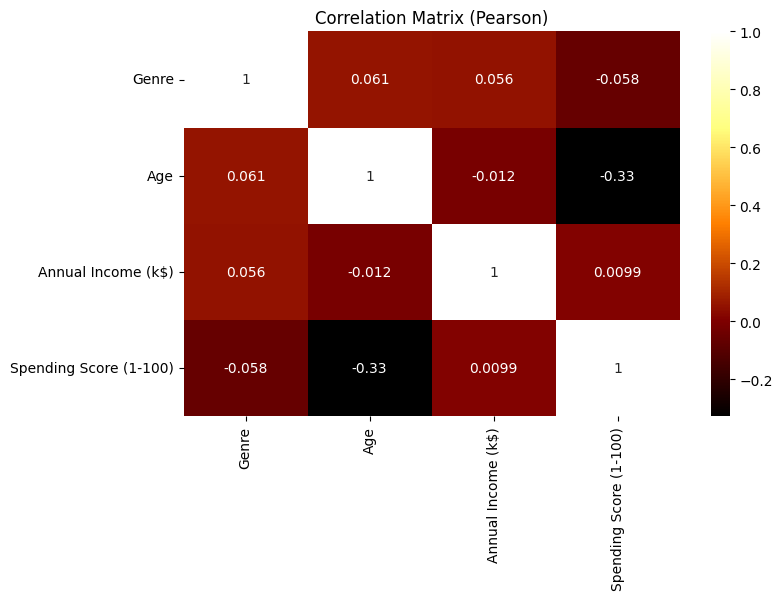

In [7]:
# корреляционная матрица
corr = df_dropped.corr("pearson")
plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap="afmhot")
plt.title("Correlation Matrix (Pearson)")
plt.show()

**Вывод**
- Между признаками слабая линейная зависимость.

## Применение алгоритма

#### Количество кластеров
Определим лучшее количество кластеров в датасете методом локтя.

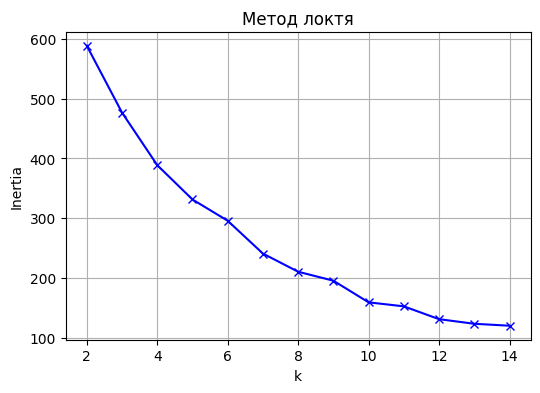

In [8]:
inertia = []
K = range(2, 15)
X = StandardScaler().fit_transform(df_dropped)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X)
    inertia.append(km.inertia_)
plt.figure(figsize=(6, 4))
plt.plot(K, inertia, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Метод локтя")
plt.grid(True)
plt.show()

**Вывод**

Будем разбивать датасет на 7 кластеров.

### Кластеризация

In [9]:
results, labels = experiment(7, 20, X)

In [10]:
results.head()

,SF (GA),SF (KMeans)
0,0.659274,0.672355
1,0.686741,0.678300
2,0.679829,0.678016
3,0.660911,0.669216
4,0.672993,0.692765


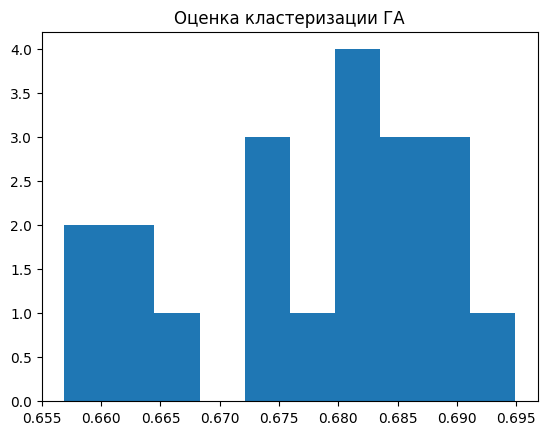

In [11]:
plt.hist(results["SF (GA)"])
plt.title("Оценка кластеризации ГА")
plt.show()

In [12]:
_, p_value = shapiro(results["SF (GA)"])
print(f"Результаты имеют нормальное распределение: {p_value}")

print(
    f"\nСреднее значение для ГА: {np.mean(results['SF (GA)'])}; стандартное отклонение: {np.std(results['SF (GA)'], ddof=1)}"
)
print(
    f"Среднее значение для KMeans: {np.mean(results['SF (KMeans)'])}; стандартное отклонение: {np.std(results['SF (KMeans)'], ddof=1)}"
)

print(f"\nЛучшая оценка GA:{max(results['SF (GA)'])}")
print(f"Лучшая оценка KMeans:{max(results['SF (KMeans)'])}")

Результаты имеют нормальное распределение: 0.28474083226289304

Среднее значение для ГА: 0.6776953983988828; стандартное отклонение: 0.011269227504648819
Среднее значение для KMeans: 0.6698200831109427; стандартное отклонение: 0.013489141421729417

Лучшая оценка GA:0.6949145102247483
Лучшая оценка KMeans:0.6927651149948172


In [14]:
df_dropped["Clusters"] = labels
means_by_cluster = df_dropped.groupby("Clusters").mean(numeric_only=True)
means_by_cluster["Count"] = df_dropped["Clusters"].value_counts().sort_index()
display(means_by_cluster)

,Genre,Age,Annual Income (k$),Spending Score (1-100),Count
Clusters,,,,,
0,1.000000,57.370370,48.259259,41.777778,27
1,0.000000,25.638889,46.666667,53.861111,36
2,0.000000,49.057692,57.442308,36.615385,52
3,0.000000,32.434783,80.391304,83.130435,23
4,0.954545,39.727273,83.772727,14.090909,22
5,1.000000,24.000000,40.090909,61.772727,22
6,1.000000,33.277778,87.111111,82.666667,18
